## Load in, pre-process, and clean the execution results

In [187]:
import os
import re
import pickle

import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm
from helpers import doi_to_directory
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline

In [188]:
# combine data sources
my_df = pd.read_csv("final_run_2/master_run_log.csv")

In [189]:
# helper functions to extract the original file names to allow better grouping
def extract_filename(file_string):
    return re.sub('__preproc__', '', '.'.join(file_string.split('.')[:-1]))

def extract_doi(doi_path):
    return doi_path.split("/")[-1]

def unique_name(row):
    return extract_doi(row['doi']) + '/' + extract_filename(row["filename"])

def doi_without_path(row):
    return extract_doi(row['doi'])

# add helpful columns to dataframe to facilitate analysis
my_df['is_error'] = ~(my_df['error'] == 'success')
my_df['is_preproc'] = my_df['filename'].str.contains("__preproc__")
my_df["unique_name"] = my_df.apply(unique_name, axis=1)
my_df['doi'] = my_df.apply(doi_without_path, axis=1)
my_df["is_library_error"] = my_df["error"].str.contains("library\s*\(")
my_df['is_wd_error'] = my_df['error'].str.contains('setwd\s*\(')
my_df['is_mirror_error'] = my_df['error'].str.contains('without setting a mirror')
my_df['is_file_error'] = (my_df['error'].str.contains('file\s*\(') |\
                          my_df['error'].str.contains('cannot open the connection') |\
                          my_df['error'].str.contains('No such file')) &\
                         ~my_df["is_library_error"] &\
                         ~my_df['is_wd_error']


In [190]:
# retrieve create dates from pickle file
with open('doi_to_create_date.pkl', 'rb') as handle:
    doi_to_create_date = pickle.load(handle)
# convert dois to directory forml
doi_to_create_date = {doi_to_directory(doi) : date for doi, date in doi_to_create_date.items()}

In [191]:
# map the dois to their create dates
my_df['create_date'] = pd.to_datetime(my_df['doi'].map(doi_to_create_date))
my_df['create_year'] = my_df['create_date'].apply(lambda x: x.year)

In [192]:
# Adding the subject data to each doi
with open('doi_to_subject.pkl', 'rb') as handle:
    doi_to_subject = pickle.load(handle)

# convert the doi to the same format
doi_to_subject = {doi_to_directory(doi) : subject for doi, subject in doi_to_subject.items()}

# get list of unique subjects
subject_set = set()
for subjects in doi_to_subject.values():
    subject_set.update(set(subjects))

# initialize empty dataframe
subject_df = pd.DataFrame()
subject_df['doi'] = pd.Series()
for subject in subject_set:
    subject_df[subject] = pd.Series()

# add on the per-doi subject data
for doi, subjects in doi_to_subject.items():
    row_dict = {}
    row_dict['doi'] = doi
    for subject in subject_set:
        row_dict[subject] = 1 if subject in subjects else 0
    subject_df = subject_df.append(row_dict, ignore_index=True)

In [193]:
my_df = my_df.join(subject_df.set_index('doi'), on=["doi"], how='inner')

# Getting the incomplete datasets for pre-processing and Vanilla
We will ignore the incomplete datasets for vanilla, but count the ones for preprocessing, since we only care about whether or not preprocessing improved on files which originally threw errors 

In [194]:
# combine data sources
vanilla_errs = []
with open('final_run_2/vanilla_std_err.txt', 'r') as vanilla_std_err:
    last_doi = ''
    for line in vanilla_std_err.readlines():
        if line.strip():
            if line.startswith('doi--'):
                last_doi = line.strip()
            elif last_doi:
                vanilla_errs.append(last_doi)

vanilla_errs = set(vanilla_errs)

# combine data sources
preproc_errs = []
with open('final_run_2/preproc_std_err.txt', 'r') as preproc_std_err:
    last_doi = ''
    for line in preproc_std_err.readlines():
        if line.strip():
            if line.startswith('doi--'):
                last_doi = line.strip()
            elif last_doi:
                preproc_errs.append(last_doi)

preproc_errs = set(preproc_errs)

In [285]:
# filter out dois that errored out for vanilla
my_df = my_df[~my_df['doi'].isin(vanilla_errs)]

In [286]:
my_df.shape

(11009, 26)

In [287]:
len(my_df['doi'].unique())

750

## Which DOIs did we miss?

In [198]:
# combine data sources
download_errs = []
with open('final_run/final_download_errors.txt', 'r') as final_download_std_err:
    last_doi = ''
    for line in final_download_std_err.readlines():
        if line.strip():
            if line.startswith('doi:'):
                last_doi = line.strip()
            elif last_doi:
                download_errs.append(last_doi)

In [199]:
missed_dois = []
reached_dois = set(my_df['doi'].unique())
with open('r_dois.txt', 'r') as all_dois:
    for line in all_dois.readlines():
        line = doi_to_directory(line.strip())
        if line not in reached_dois:
            missed_dois.append(line)

In [200]:
len(download_errs)

36

In [201]:
len(missed_dois)

96

In [202]:
len(set(my_df['doi']))

750

## Base stats for trying to run the original scripts

In [204]:
vanilla_df = my_df[(~my_df['is_preproc']) & (my_df['run_type'] == "source")]

In [205]:
len(vanilla_df['unique_name'].unique())

2839

In [206]:
len(vanilla_df['doi'].unique())

747

In [207]:
vanilla_df.drop_duplicates(['unique_name'], keep="last", inplace=True)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [208]:
vanilla_df.shape

(2839, 26)

Proportion of original scripts that ran

In [209]:
np.sum(~vanilla_df['is_error']) 

408

In [210]:
np.sum(~vanilla_df['is_error'])  / (len(vanilla_df) * 1.0)

0.1437125748502994

In [211]:
len(vanilla_df)

2839

Number of errors

In [212]:
# isolate errors in their own dataframe
error_vanilla = vanilla_df[(vanilla_df['is_error'])]

In [213]:
len(error_vanilla)

2431

Number of library errors

In [214]:
np.sum(error_vanilla['is_library_error'])

363

In [215]:
np.sum(error_vanilla['is_library_error']) / (len(error_vanilla) * 1.0)

0.1493212669683258

Number of working directory errors

In [216]:
np.sum(error_vanilla['is_wd_error']) 

696

In [217]:
np.sum(error_vanilla['is_wd_error']) / (len(error_vanilla) * 1.0)

0.2863019333607569

File Errors

In [218]:
np.sum(error_vanilla['is_file_error'])

802

In [219]:
np.sum(error_vanilla['is_file_error']) / (len(error_vanilla) * 1.0)

0.3299053887289181

Using cran without a mirror

In [220]:
np.sum(error_vanilla['is_mirror_error']) / (len(error_vanilla) * 1.0)

0.03537638831756479

DOIs for which there were no errors

In [221]:
# get list of dois for which all files ran successfully
perfect_dois = []
for doi in vanilla_df['doi'].unique():
    doi_df = vanilla_df[vanilla_df['doi'] == doi]
    if len(doi_df) == sum(doi_df['is_error'] == 0):
        perfect_dois.append(doi)

In [222]:
len(perfect_dois) / (len(vanilla_df['doi'].unique()) * 1.0)

0.03614457831325301

## Base stats for preprocessed scripts

Proportion of preprocessed files which ran:

In [224]:
preproc_df = my_df[my_df['is_preproc'] & (my_df['run_type'] == 'source')]

In [225]:
preproc_df.drop_duplicates(['unique_name'], keep="last", inplace=True)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Proportion of preprocessed files which ran:

In [226]:
# isolate errors in their own dataframe
error_preproc = preproc_df[preproc_df['unique_name'].isin(set(error_vanilla['unique_name']))]

In [233]:
error_preproc.shape

(2329, 26)

In [227]:
np.sum(error_preproc['is_library_error'])

8

In [228]:
np.sum(error_preproc['is_wd_error'])

12

In [229]:
np.sum(error_preproc['is_file_error'])

1400

In [230]:
np.sum(error_preproc['is_mirror_error'])

10

In [231]:
np.sum(~error_preproc['is_error'])

62

In [232]:
np.sum(~error_preproc['is_error']) / (len(error_preproc) * 1.0)

0.026620867325032202

In [288]:
error_preproc[error_preproc['is_library_error'] | 
              error_preproc['is_wd_error'] |
              error_preproc['is_mirror_error']].to_csv('preproc_errors.csv')

## Analyzing Missing Files

In [235]:
with open("final_run/missing_files.pkl", 'rb') as handle:
    missing_files = pickle.load(handle)

In [236]:
# filter out missing files with none missing
missing_files = {key:value for key,value in missing_files.items() if value}

In [237]:
# filter missing orig_files
missing_file_paths = set()

In [238]:
# construct origin_file paths with doi
for doi, missing_list in missing_files.items():
    for missing_file in missing_list:
        try:
            source_name, _ = missing_file.split(',')
            source_name = '.'.join(source_name.split('.')[:-1])
            missing_file_paths.add('/'.join([doi, source_name]))
        except:
            pass

In [239]:
missing_file_dois = missing_files.keys()

In [240]:
file_error_dois = list(error_preproc[error_preproc['is_file_error']]['doi'].unique())

In [241]:
error_preproc[error_preproc['is_file_error'] & (error_preproc['unique_name'].isin(missing_file_paths))].shape[0]

1205

In [242]:
error_preproc[error_preproc['is_file_error'] & (error_preproc['unique_name'].isin(missing_file_paths))].shape[0]\
/ (np.sum(error_preproc['is_file_error']) * 1.0)


0.8607142857142858

A very naive way of detecting missing files revealed that 83.11% of file errors can be attributed to non-existent files.

In [243]:
error_preproc[error_preproc['is_file_error'] &\
              error_preproc['doi'].isin(set(file_error_dois) -\
                                        set(missing_file_dois))].to_csv("preproc_file_errors.csv")

## Assessing the relationship between errors and dataset age

In [244]:
error_vanilla.columns

Index(['doi', 'filename', 'run_type', 'error', 'is_error', 'is_preproc',
       'unique_name', 'is_library_error', 'is_wd_error', 'is_mirror_error',
       'is_file_error', 'create_date', 'create_year', 'Social Sciences',
       'Computer and Information Science', 'Chemistry',
       'Medicine, Health and Life Sciences', 'Physics', 'Engineering', 'Other',
       'Business and Management', 'Mathematical Sciences',
       'Arts and Humanities', 'Agricultural Sciences', 'Law',
       'Earth and Environmental Sciences'],
      dtype='object')

In [245]:
# get the number of data files per year
years_df = vanilla_df.groupby('create_year')['unique_name'].nunique().to_frame()

In [246]:
years_df['error_count'] = error_vanilla.groupby('create_year')['unique_name'].nunique()

In [247]:
years_df = years_df.reset_index()

In [248]:
years_df['create_year'] = years_df['create_year'].astype(int)

In [249]:
years_df['error_rate'] = years_df['error_count'] / years_df['unique_name']

In [250]:
years_df

,create_year,unique_name,error_count,error_rate
0,2015,282,253,0.897163
1,2016,927,786,0.847896
2,2017,1416,1204,0.850282
3,2018,212,186,0.877358


In [251]:
grouped_years_df = pd.DataFrame()
for column in ['create_year', 'number', 'Count Type']:
    grouped_years_df[column] = pd.Series()
for _, row in years_df.iterrows():
    grouped_years_df = grouped_years_df.append({'create_year': row['create_year'], 
                             'number': row['error_count'],
                             'Count Type': 'Number of Errors'},
                            ignore_index=True)
    grouped_years_df = grouped_years_df.append({'create_year': row['create_year'], 
                             'number': row['unique_name'],
                             'Count Type': 'Number of Scripts'},
                            ignore_index=True)

In [252]:
for col in  ['create_year', 'number']:
    grouped_years_df[col] = grouped_years_df[col].astype(int)

In [253]:
grouped_years_df

,create_year,number,Count Type
0,2015,253,Number of Errors
1,2015,282,Number of Scripts
2,2016,786,Number of Errors
3,2016,927,Number of Scripts
4,2017,1204,Number of Errors
5,2017,1416,Number of Scripts
6,2018,186,Number of Errors
7,2018,212,Number of Scripts


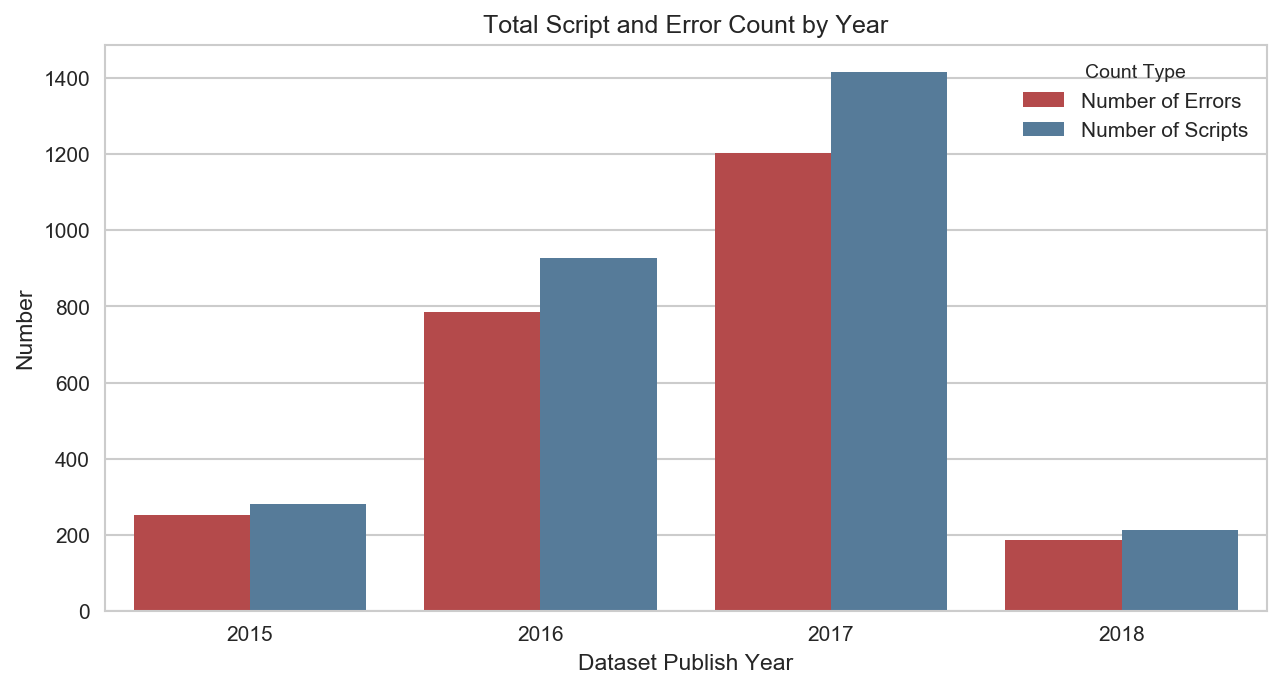

In [254]:
plt.figure(figsize=(10, 5), dpi=150)
sns.set(color_codes=True)
sns.set_style("whitegrid")
sns.set_context("notebook")
ax = sns.barplot(x="create_year", y="number", hue="Count Type", data=grouped_years_df, palette=sns.color_palette("Set1", n_colors=3, desat=.7))
ax.set_title('Total Script and Error Count by Year')
ax.set_xlabel("Dataset Publish Year")
ax.set_ylabel("Number")
plt.savefig('error_count_by_year.pdf', filetype="pdf")

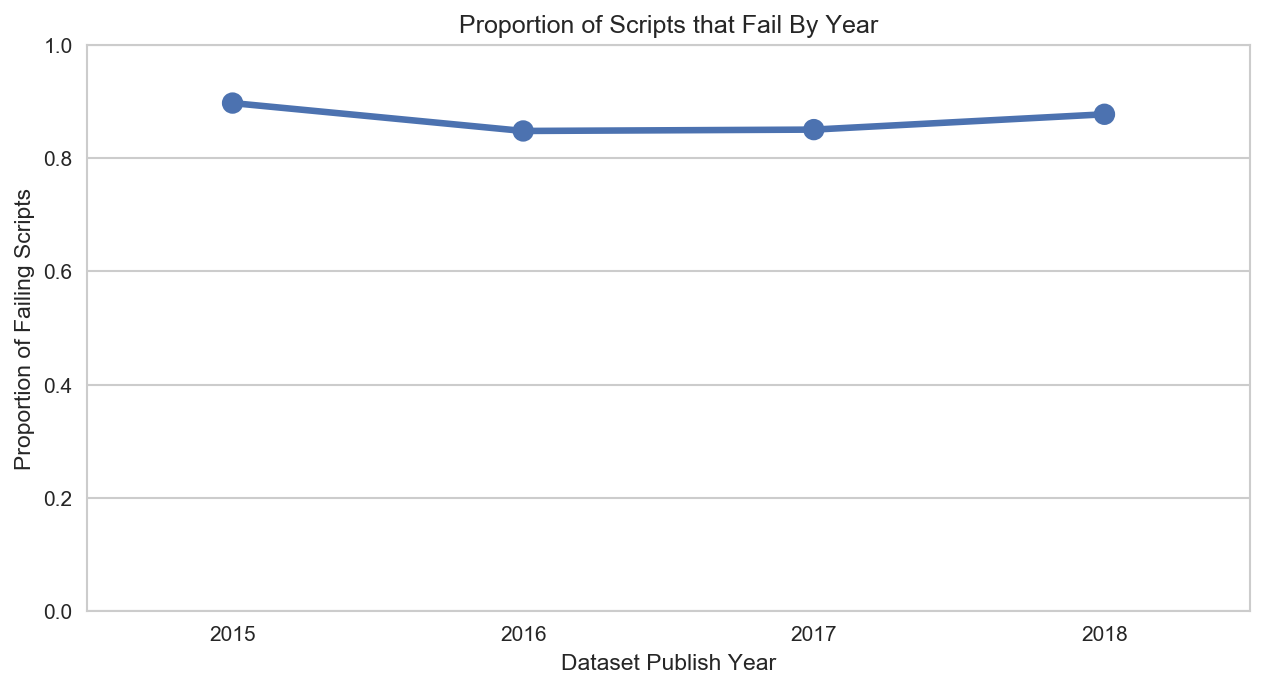

In [255]:
plt.figure(figsize=(10, 5), dpi=150)
sns.set(color_codes=True)
sns.set_style("whitegrid")
sns.set_context("notebook")
ax = sns.pointplot(x=years_df['create_year'], y=years_df['error_rate'])
ax.set_ylim(0,1)
ax.set_title('Proportion of Scripts that Fail By Year')
ax.set_xlabel("Dataset Publish Year")
ax.set_ylabel("Proportion of Failing Scripts")
plt.savefig('error_rates.pdf', filetype="pdf")


## Assessing error rate within datasets

In [256]:
# get the number of files for each doi
files_by_doi = vanilla_df.groupby('doi')['unique_name'].nunique().to_frame()

In [257]:
files_by_doi['num_errors'] = vanilla_df.groupby('doi')['is_error'].sum()

In [258]:
# reset index so doi is just a column and not the id column
files_by_doi = files_by_doi.reset_index()

In [259]:
files_by_doi['error_rate'] = files_by_doi['num_errors'] / files_by_doi['unique_name']

In [260]:
len(files_by_doi)

747

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


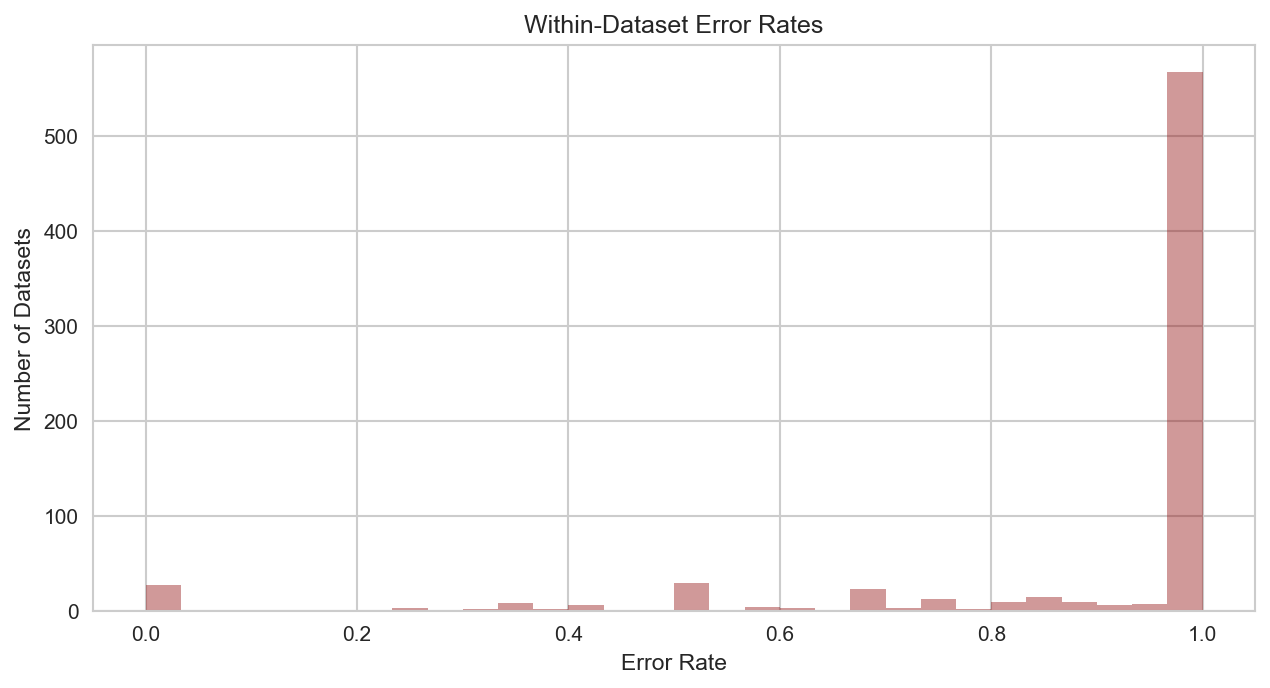

In [261]:
plt.figure(figsize=(10, 5), dpi=150)
sns.set(color_codes=True)
sns.set_style("whitegrid")
sns.set_context("notebook")
ax = sns.distplot(files_by_doi['error_rate'], kde=False, color="DarkRed", bins=30)
ax.set_title('Within-Dataset Error Rates')
ax.set_xlabel("Error Rate")
ax.set_ylabel("Number of Datasets")
plt.savefig('error_rate_in_dataset.pdf', filetype="pdf")

## Assessing error rate between subjects

In [263]:
error_corr_df = vanilla_df.drop(['doi', 'filename', 'run_type', 'error', 'unique_name',
                                 'create_date', 'create_year', 'is_preproc'],
                                axis=1)
for column in error_corr_df.columns:
    error_corr_df[column] = error_corr_df[column].astype(float)

Getting the overall number in subjects

In [264]:
error_corr_df.corr()[['is_error', 'is_library_error', 'is_wd_error', 'is_mirror_error', 'is_file_error']]

,is_error,is_library_error,is_wd_error,is_mirror_error,is_file_error
is_error,1.000000,0.156861,0.233470,0.072408,0.257057
is_library_error,0.156861,1.000000,-0.218208,-0.067674,-0.240253
is_wd_error,0.233470,-0.218208,1.000000,-0.100726,-0.357590
is_mirror_error,0.072408,-0.067674,-0.100726,1.000000,-0.110902
is_file_error,0.257057,-0.240253,-0.357590,-0.110902,1.000000
Social Sciences,0.180589,0.021434,0.055474,0.034619,0.046424
Computer and Information Science,0.033567,-0.038183,-0.035923,-0.004635,0.059201
Chemistry,-0.026967,-0.010166,0.015729,-0.004693,-0.016660
"Medicine, Health and Life Sciences",-0.173540,-0.003079,-0.056088,-0.023968,-0.045165
Physics,0.036204,-0.033837,-0.041025,-0.015619,0.105151


Correlation analysis doesn't reveal any striking results

### Overall error rates across subjects

In [265]:
def calculate_subject_error_rate(subject, df):
    sub_df = df[df[subject].astype(bool)]
    return sum(sub_df['is_error']) / (len(sub_df) * 1.0), len(sub_df)

In [355]:
subjects_list = ['Social Sciences',
       'Computer and Information Science', 
       'Medicine, Health and Life Sciences', 'Physics', 'Engineering', 'Other',
       'Business and Management', 'Mathematical Sciences',
       'Arts and Humanities', 'Agricultural Sciences', 'Law',
       'Earth and Environmental Sciences']

In [356]:
subject_err_df = pd.DataFrame()
for column in ['Subject', 'is_error']:
    subject_err_df = pd.Series()
for subject in subjects_list:
    subject_count = np.sum(vanilla_df[subject])
    subject_err = np.sum(vanilla_df[subject].astype(bool) & vanilla_df['is_error'])
    for num in range(subject_err):
        subject_err_df = subject_err_df.append(pd.DataFrame({'Subject': [subject], 'is_error': [1]}),
                              ignore_index=True, verify_integrity=False)
    for num in range(int(subject_count) - subject_err):
        subject_err_df = subject_err_df.append(pd.DataFrame({'Subject': [subject], 'is_error': [0]}),
                              ignore_index=True, verify_integrity=False)

In [357]:
subject_error_rates = pd.DataFrame()
for col in ['Subject', 'Error Rate', 'Total Number']:
    subject_error_rates[col] = pd.Series()
for subject in subject_set:
    # chemistry has no members, want to avoid dividing by 0
    if subject != "Chemistry":
        error_rate, total_num = calculate_subject_error_rate(subject, vanilla_df)
        subject_error_rates = subject_error_rates.append({'Subject': subject,
                                                          'Error Rate': error_rate,
                                                          'Total Number': total_num},
                                                        ignore_index=True)
        

In [358]:
subject_error_rates['Total Number'] = subject_error_rates['Total Number'].astype(int)

In [359]:
subject_error_rates.to_csv("subject_error_rates.csv", index=False)

In [297]:
for _, row in subject_error_rates.iterrows():
    print(row['Subject'])
    p_hat = row['Error Rate']
    print(np.sqrt((p_hat * (1 - p_hat)) / row['Total Number']))

Social Sciences
0.0064598871183862904
Computer and Information Science
0.03286026473058831
Medicine, Health and Life Sciences
0.04834769988284787
Physics
0.0
Engineering
0.1788854381999832
Other
0.09229618630166093
Business and Management
0.0
Mathematical Sciences
0.059974679167611115
Arts and Humanities
0.06708203932499368
Agricultural Sciences
0.09757809372497497
Law
0.05557580101213501
Earth and Environmental Sciences
0.04790583480943956


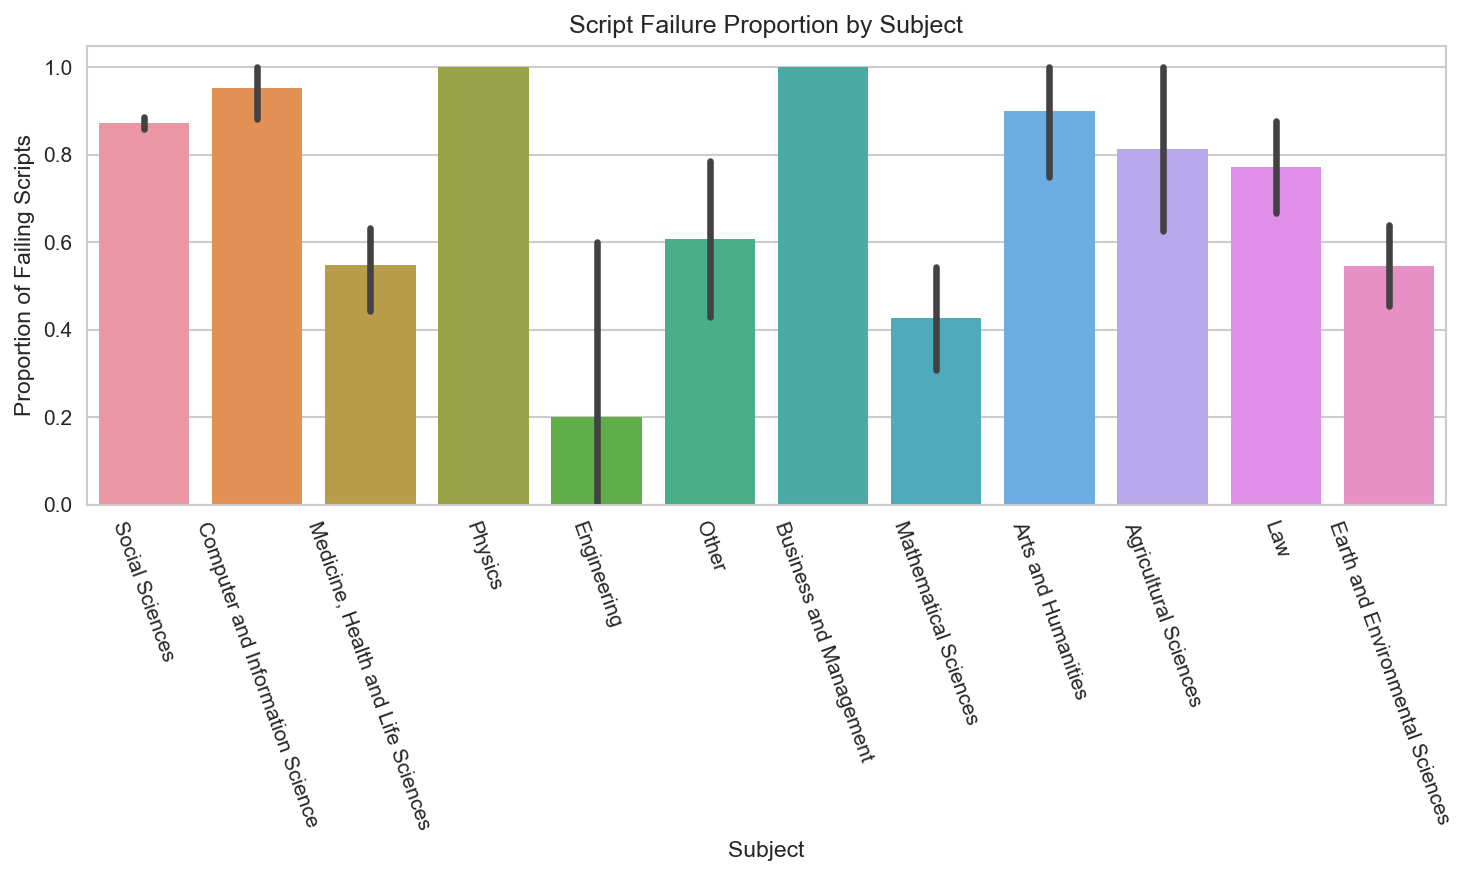

In [360]:
plt.figure(figsize=(10, 6), dpi=150)
plt.xticks(rotation=-70)
sns.set(color_codes=True)
sns.set_style("whitegrid")
sns.set_context("notebook")
ax = sns.barplot(x=subject_err_df['Subject'], 
                 y=subject_err_df['is_error'])
ax.set_title('Script Failure Proportion by Subject')
ax.set_xlabel("Subject")
ax.set_ylabel("Proportion of Failing Scripts")
plt.tight_layout()
plt.savefig('Error_rate_by_subject.pdf', filetype="pdf")

## Checking for provR bugs (features)

In [271]:
vanilla_success = vanilla_df[vanilla_df['error'] == 'success']

In [272]:
len(vanilla_success['unique_name'].unique())

408

In [273]:
success_files = vanilla_success['unique_name'].unique()

In [279]:
provR_success = my_df[~my_df['is_preproc'] &\
                      (my_df['run_type'] == 'provR') &\
                      my_df['unique_name'].isin(success_files)]

In [281]:
provR_success.shape

(405, 26)

In [282]:
len(vanilla_success)

408

In [283]:
np.sum(~provR_success['is_error']) / (1.0 * len(provR_success))

0.9259259259259259

In [284]:
provR_success[~(provR_success['error'] == 'success')].to_csv("provr_errors.csv")

In [289]:
np.sum(~provR_success['is_error'])

375